# LSTM multivariado

Se importan las librerías.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

Se importan los datos.

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

Se conservan los datos del día.

In [ ]:
df = df.between_time('08:00:00','17:00:00')
df.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMAX1H,RHMIN1H,PRSUM1H,PAAVG1H,PAMAX1H,PAMIN1H,WS1HA,WS1HX,WD1HA
Local_Time,,,,,,,,,,,,
2015-01-01 08:00:00,107.0,12.2,9.5,96.0,89.0,0.0,743.5,743.7,743.1,2.5,4.6,42
2015-01-01 09:00:00,394.0,15.1,12.2,89.0,76.0,0.0,743.8,743.9,743.7,3.3,5.8,59
2015-01-01 10:00:00,728.0,18.1,15.1,79.0,57.0,0.0,743.7,743.9,743.4,4.4,8.4,40
2015-01-01 11:00:00,428.0,18.4,16.7,66.0,58.0,0.0,743.2,743.4,742.8,4.0,8.1,35
2015-01-01 12:00:00,403.0,18.5,17.2,65.0,55.0,0.0,742.6,742.9,742.3,3.5,7.6,34


Se obtienen los datos con los que se va a entrenar el modelo.

In [ ]:
df = df[['SRGLOAVG1H','TAMAX1H', 'TAMIN1H', 'RHMIN1H','RHMAX1H']]

In [ ]:
df.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMIN1H,RHMAX1H
Local_Time,,,,,
2015-01-01 08:00:00,107.0,12.2,9.5,89.0,96.0
2015-01-01 09:00:00,394.0,15.1,12.2,76.0,89.0
2015-01-01 10:00:00,728.0,18.1,15.1,57.0,79.0
2015-01-01 11:00:00,428.0,18.4,16.7,58.0,66.0
2015-01-01 12:00:00,403.0,18.5,17.2,55.0,65.0


Se importan los datos de prueba.

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H', 'TAMIN1H', 'RHMIN1H','RHMAX1H']]

In [ ]:
df_test = df_test.between_time('08:00:00','17:00:00')

In [ ]:
df_test.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMIN1H,RHMAX1H
Local_Time,,,,,
2016-08-08 08:00:00,136.0,12.2,10.8,89.0,95.0
2016-08-08 09:00:00,337.0,15.2,12.3,73.0,90.0
2016-08-08 10:00:00,303.0,15.1,13.6,70.0,81.0
2016-08-08 11:00:00,549.0,16.5,13.3,71.0,88.0
2016-08-08 12:00:00,577.0,17.6,15.8,65.0,77.0


## Creación del modelo LSTM multivariado

Se normalizan los datos

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(df)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se establecen las horas de retraso y el número de features a considerar, en este caso, se utilizarán 3 como ejemplo.

In [ ]:
n_input = 22 # horas hacia atrás, features
n_output = 1 # horas predichas
n_features = 3 # variables de entrada
generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)

In [ ]:
X_train = []
y_train = []

In [ ]:
for batch in generator:
  if(len(batch[1])==n_output):
    X_train.append(batch[0][0])
    y_train.append(batch[1])

In [ ]:
scaled_train[0]

array([0.07730673, 0.40860215, 0.26966292, 0.94285714])

In [ ]:
X_train[0]

array([[0.07730673, 0.40860215, 0.26966292, 0.94285714],
       [0.31587697, 0.56451613, 0.35955056, 0.84285714],
       [0.59351621, 0.72580645, 0.48314607, 0.7       ],
       [0.34413965, 0.74193548, 0.43820225, 0.51428571],
       [0.32335827, 0.74731183, 0.38202247, 0.5       ],
       [0.57772236, 0.83333333, 0.30337079, 0.44285714]])

In [ ]:
scaled_train[6:12,0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [ ]:
y_train[0]

array([0.31837074, 0.48212801, 0.24438903, 0.10141313, 0.06899418,
       0.08645054])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(n_input, n_features+1)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 75)                24000     
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 24,076
Trainable params: 24,076
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=7,verbose=True,batch_size=100)
#model.fit(X_train,y_train,epochs=12)

Epoch 1/7
5828/5828 [==============================] - 49s 8ms/step - loss: 0.0197
Epoch 2/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0161
Epoch 3/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0155
Epoch 4/7
5828/5828 [==============================] - 47s 8ms/step - loss: 0.0152
Epoch 5/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0149
Epoch 6/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0148
Epoch 7/7
5828/5828 [==============================] - 48s 8ms/step - loss: 0.0147


Gráfica del error a través de las épocas de entrenamiento.

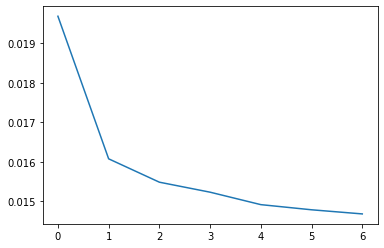

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
eval = scaled_train[-n_input:,:].reshape(1,n_input,4)

In [ ]:
eval

array([[[0.35625518, 0.72307692, 0.77506112, 0.40740741],
        [0.1963546 , 0.68205128, 0.74572127, 0.41975309],
        [0.16901408, 0.39487179, 0.43276284, 0.71604938],
        [0.22700911, 0.51282051, 0.53056235, 0.60493827],
        [0.5956918 , 0.65641026, 0.66748166, 0.4691358 ],
        [0.76304888, 0.73333333, 0.78484108, 0.41975309],
        [0.81524441, 0.82051282, 0.82885086, 0.40740741],
        [0.45153273, 0.80512821, 0.85819071, 0.34567901],
        [0.37862469, 0.80512821, 0.87775061, 0.32098765],
        [0.51449876, 0.80512821, 0.86797066, 0.28395062],
        [0.35211268, 0.80512821, 0.87775061, 0.28395062],
        [0.14001657, 0.74358974, 0.79462103, 0.34567901],
        [0.06130903, 0.41538462, 0.53545232, 0.81481481],
        [0.11019056, 0.46666667, 0.56968215, 0.7654321 ],
        [0.21789561, 0.56923077, 0.62347188, 0.67901235],
        [0.46478873, 0.63589744, 0.68704156, 0.64197531],
        [0.49047225, 0.67692308, 0.72616137, 0.5308642 ],
        [0.298

In [ ]:
predictions = model.predict(eval)[0]
predictions

array([0.07663663], dtype=float32)

Para obtener los valores reales se necesita de una matriz, pues ahora se trabaja con un modelo multivariado.

In [ ]:
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features) )

Se colocan las predicciones normalizadas en la primera columna, la radiación solar.

In [ ]:
test_predictions[:,0] = predictions

Se transforman los datos a la escala original.

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions[:,0]

array([102.50040917])

In [ ]:
df_test['SRGLOAVG1H'][:6]

Local_Time
2016-08-08 08:00:00    136.0
2016-08-08 09:00:00    337.0
2016-08-08 10:00:00    303.0
2016-08-08 11:00:00    549.0
2016-08-08 12:00:00    577.0
2016-08-08 13:00:00    334.0
Name: SRGLOAVG1H, dtype: float64

Se evalúa el error para todo el conjunto de pruebas.

In [ ]:
predictions=[]

In [ ]:
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])

In [ ]:
predictions = np.ndarray.flatten(np.array(predictions))  
test_predictions =  np.zeros(shape=(len(predictions), 1+n_features))
test_predictions[:,0] = predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

In [ ]:
rsg_predictions = true_predictions[:,0]


In [ ]:
errorMSE = mean_squared_error(true_values,rsg_predictions)
errorMAE = mean_absolute_error(true_values,rsg_predictions)

In [ ]:
errorMAE

132.43248900529696

## Grid search

Ahora se buscará la optimización de hiperparámetros. El modelo final utilizará las cuatro variables que fueron seleccionadas en el notebook anterior: temperatura máxima y mínima, humedad máxima y mínima.

Se crea una función para generar modelos de varias capas y número de neuronas.

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
model = create_Model(22)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 22, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


Esta lista sirve para almacenar los resultados que ya han sido obtenidos, esto se debe a que Colab interrumpe las ejecuciones después de cierto tiempo, así que hay que tomar en cuenta las combinaciones que ya se han probado.

In [ ]:
resultados_anteriores = []

In [ ]:
import json

Se importan los resultados ya obtenidos.

In [ ]:
with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_multivariado_RS.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [ ]:
df_resultados_anteriores = pd.DataFrame(resultados_anteriores)

In [ ]:
combinaciones_anteriores = []

In [ ]:
df_resultados = df_resultados_anteriores

Se almacenan las combinaciones ya probadas para no volver a ejecutarlas.

In [ ]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
len(combinaciones_anteriores)

227

In [ ]:
combinaciones_anteriores[-1]

(26, 100, 200, 2)

In [ ]:
df_resultados[df_resultados['RMSE']==df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
147,20,125,200,1,23950.456307,119.294276,154.75935


Se utiliza el RMSE mínimo como referencia para elegir al mejor modelo.

In [ ]:
min_RMSE = 154.75934965784236

Se pruebas las posibles combinaciones en busca de la mejor.

In [ ]:
for retrasos in range(18,28,2): #hasta dos días y medio hacia el pasado
  for num_neuronas in range(50,126,25): 
    for batch_size in range(50,201,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers
        })
        n_input = retrasos # horas hacia atrás
        n_output = 1
        n_features = 4 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers,n_features=n_features)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])

        predictions = np.ndarray.flatten(np.array(predictions))  
        test_predictions =  np.zeros(shape=(len(predictions), 5))
        test_predictions[:,0] = predictions
        true_predictions = scaler.inverse_transform(test_predictions)
        rsg_predictions = true_predictions[:,0]
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)

        errorMSE = mean_squared_error(true_values,rsg_predictions)
        errorMAE = mean_absolute_error(true_values,rsg_predictions)
        errorRMSE = np.sqrt(errorMSE)
        if(errorRMSE<min_RMSE):
          print('BEST')
          model.save('./drive/MyDrive/DatosInvestigacion/LSTM_multivariado_RS.h5')
          min_RMSE = errorRMSE

        print('RMSE:',errorRMSE)
        print('MAE',errorMAE)
        print('min RMSE',min_RMSE)
        resultado = {
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
            'MSE':errorMSE,
            'MAE':errorMAE,
            'RMSE':errorRMSE
        }
        with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_multivariado_RS.txt","a") as file:
          resultado = json.dumps(resultado)
          file.write(resultado)
          file.write('\n')

{'Retrasos': 26, 'Neuronas LSTM': 100, 'Batch size': 200, 'LSTM Layers': 3}
RMSE: 165.67400297936277
MAE 127.39242245571758
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 50, 'LSTM Layers': 1}
RMSE: 155.99537268420647
MAE 119.76623563074105
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 50, 'LSTM Layers': 2}
RMSE: 162.6351921863417
MAE 124.29351295342713
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 50, 'LSTM Layers': 3}
RMSE: 162.22604304507524
MAE 127.15410123468796
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 100, 'LSTM Layers': 1}
RMSE: 156.03258022190013
MAE 121.64138619968021
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 100, 'LSTM Layers': 2}
RMSE: 158.33368321194382
MAE 122.82039751848687
min RMSE 154.75934965784236
{'Retrasos': 26, 'Neuronas LSTM': 125, 'Batch size': 100, 'LSTM Layers': 3}
RMSE: 170.113341

Al final, se tienen estos resultados.

In [ ]:
df_resultados

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
0,18,50,50,1,24770.212133,121.020835,157.385552
1,18,50,50,2,25999.216877,123.359002,161.242727
2,18,50,50,3,25229.138743,122.652118,158.836831
3,18,50,100,1,24744.599500,121.633604,157.304162
4,18,50,100,2,24247.153613,119.455278,155.714976
...,...,...,...,...,...,...,...
235,26,125,150,2,24586.416804,120.473327,156.800564
236,26,125,150,3,28024.245098,129.916946,167.404436
237,26,125,200,1,25323.089098,120.420508,159.132301
238,26,125,200,2,27358.867938,125.882562,165.405163


In [ ]:
df_resultados[df_resultados['MAE'] == df_resultados['MAE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
87,24,50,150,1,23986.244262,118.31061,154.874931


Se toma como mejor, el modelo con el RMSE más pequeño, aunque la diferencia con el MAE más pequeño tampoco es tan grande.

In [ ]:
df_resultados[df_resultados['RMSE'] == df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
147,20,125,200,1,23950.456307,119.294276,154.75935


In [ ]:
df_resultados.to_csv('./drive/MyDrive/DatosInvestigacion/lstm_multivariado_RS_resultados.csv',index=False)

## Mejor modelo

Se grafica el error a través de las distintas combinaciones.

### Número de retrasos

In [ ]:
import seaborn as sns

El mejor número de retrasos es 20.

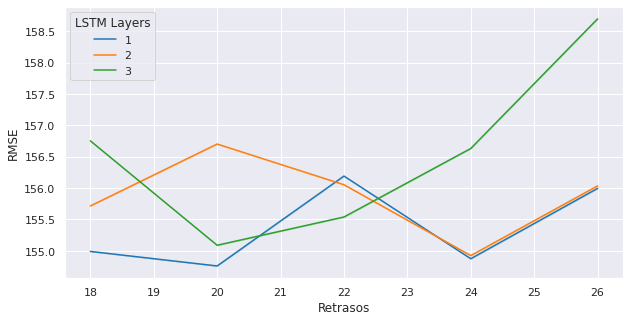

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='RMSE',hue='LSTM Layers',palette='tab10',ci=0, estimator=np.min)

## Número de neuronas

El mejor número de neuronas es 125.

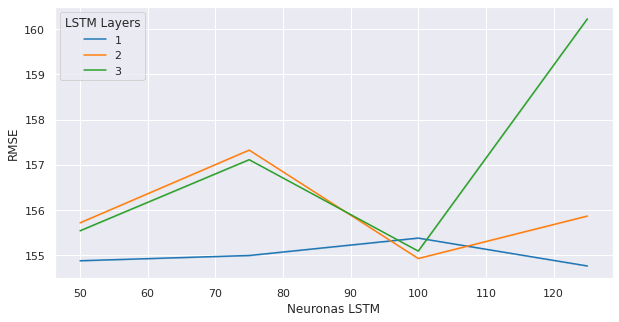

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Batch size

El mejor batch size es 200.

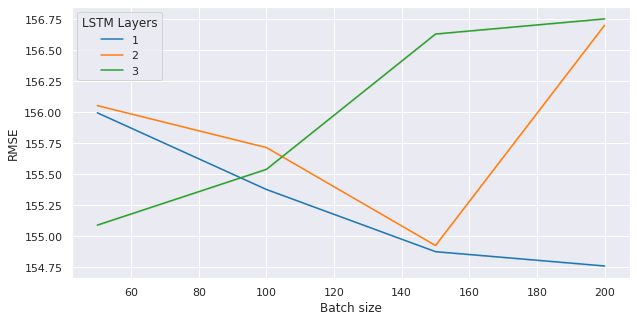

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Batch size', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

## Conclusiones

* 1 capa LSTM obtiene mejores resultados.
* El mejor batch size es 50.
* El mejor número de neuronas es 125.
* El mejor número de retrasos es 20.